## Step 1: Import Required Libraries

In [126]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

# Import plotly for interactive visualizations
import plotly.express as px
import plotly.graph_objects as go

print("Libraries imported successfully")

Libraries imported successfully


## Step 2: Define Helper Functions and Mappings

In [127]:
# Define fibre name to origin mapping (Natural vs Man-made)
FIBRE_ORIGIN = {
    # Natural - Plant-based (Cellulose)
    'Cotton': 'Natural',
    'Linen': 'Natural',
    'Jute': 'Natural',
    'Denim': 'Natural',
    'Flax': 'Natural',
    'Hemp': 'Natural',
    'Kapok': 'Natural',
    'Kenaf': 'Natural',
    'Rafia': 'Natural',
    'Ramie': 'Natural',
    'Sisal': 'Natural',
    'Cacao': 'Natural',
    'Coir': 'Natural',
    
    # Natural - Animal-based (Protein)
    'Silk': 'Natural',
    'Wool': 'Natural',
    'Alpaca': 'Natural',
    'Rabbit': 'Natural',
    'Camel': 'Natural',
    'Goat': 'Natural',
    'Goose': 'Natural',
    'Llama': 'Natural',
    'Musk Ox': 'Natural',
    'Yak': 'Natural',
    
    # Man-made
    'Polyester': 'Man-made',
    'Nylon': 'Man-made',
    'Acrylic': 'Man-made',
    'Modacrylic': 'Man-made',
    'Aramid': 'Man-made',
    'Carbon': 'Man-made',
    'Chlorofiber': 'Man-made',
    'Olefin': 'Man-made',
    'PBI': 'Man-made',
    'Polyacrylate': 'Man-made',
    'Spandex': 'Man-made',
    'Sulfar': 'Man-made',
    'Rayon': 'Man-made',
    'Viscose': 'Man-made',
    'Lyocell': 'Man-made',
    'Modal': 'Man-made',
    'Acetate': 'Man-made'
}

# Natural fibre classification - Plant-based (Cellulose)
CELLULOSE_FIBRES = ['Cotton', 'Linen', 'Jute', 'Bamboo', 'Denim', 'Flax', 'Hemp', 
                    'Kapok', 'Kenaf', 'Rafia', 'Ramie', 'Sisal', 'Cacao', 'Coir']

# Natural fibre classification - Animal-based (Protein)
PROTEIN_FIBRES = ['Silk', 'Wool', 'Alpaca', 'Rabbit', 'Camel', 'Goat', 
                  'Goose', 'Llama', 'Musk Ox', 'Yak']

# Regenerated cellulose fibres
REGENERATED_CELLULOSE = ['Rayon', 'Viscose', 'Lyocell', 'Modal']

# Acetate fibres
ACETATE_FIBRES = ['Acetate']

# Fiber name abbreviations for Sample_ID generation
FIBRE_ABBREVIATIONS = {
    # Natural - Cellulose
    'Cotton': 'COT',
    'Linen': 'LIN',
    'Jute': 'JUT',
    'Bamboo': 'BAM',
    'Denim': 'DEN',
    'Flax': 'FLX',
    'Hemp': 'HMP',
    'Kapok': 'KPK',
    'Kenaf': 'KNF',
    'Rafia': 'RAF',
    'Ramie': 'RAM',
    'Sisal': 'SIS',
    'Cacao': 'CAC',
    'Coir': 'COI',
    'Unknown': 'UNK',
    
    # Natural - Protein
    'Silk': 'SIL',
    'Wool': 'WOL',
    'Alpaca': 'ALP',
    'Rabbit': 'RAB',
    'Camel': 'CAM',
    'Goat': 'GOT',
    'Goose': 'GOS',
    'Llama': 'LLM',
    'Musk Ox': 'MUX',
    'Yak': 'YAK',
    
    # Man-made
    'Polyester': 'PES',
    'Nylon': 'NYL',
    'Acrylic': 'ACR',
    'Modacrylic': 'MAC',
    'Aramid': 'ARM',
    'Carbon': 'CAR',
    'Chlorofiber': 'CLF',
    'Olefin': 'OLE',
    'PBI': 'PBI',
    'Polyacrylate': 'PAC',
    'Spandex': 'SPX',
    'Sulfar': 'SUL',
    'Rayon': 'RAY',
    'Viscose': 'VIS',
    'Lyocell': 'LYO',
    'Modal': 'MOD',
    'Acetate': 'ACT'
}

print("Fiber classification mappings defined")
print(f"Natural - Cellulose fibres: {CELLULOSE_FIBRES}")
print(f"Natural - Protein fibres: {PROTEIN_FIBRES}")
print(f"Regenerated cellulose fibres: {REGENERATED_CELLULOSE}")
print(f"Acetate fibres: {ACETATE_FIBRES}")
print(f"Man-made fibres: Polyester, Nylon, Acrylic, Modacrylic, Aramid, Rayon, Acetate, Olefin, etc.")

Fiber classification mappings defined
Natural - Cellulose fibres: ['Cotton', 'Linen', 'Jute', 'Bamboo', 'Denim', 'Flax', 'Hemp', 'Kapok', 'Kenaf', 'Rafia', 'Ramie', 'Sisal', 'Cacao', 'Coir']
Natural - Protein fibres: ['Silk', 'Wool', 'Alpaca', 'Rabbit', 'Camel', 'Goat', 'Goose', 'Llama', 'Musk Ox', 'Yak']
Regenerated cellulose fibres: ['Rayon', 'Viscose', 'Lyocell', 'Modal']
Acetate fibres: ['Acetate']
Man-made fibres: Polyester, Nylon, Acrylic, Modacrylic, Aramid, Rayon, Acetate, Olefin, etc.


In [128]:
def extract_binder_id_from_header(header_text):
    """
    Extract binder ID from the header text in raw CSV files.
    
    Patterns to match:
    - Standard format: "6.2. Natural Brown Fiber" -> "6.2"
    - Alternative: "90. Du Pont" -> "90"
    - Non-standard: "100% Lyocell 8/2 (Red)" -> None
    
    Parameters:
    -----------
    header_text : str
        Second column value from first row of raw CSV
    
    Returns:
    --------
    str or None
        Binder ID if found, None otherwise
    """
    if pd.isna(header_text) or header_text.strip() == '':
        return None
    
    # Try to match patterns: "6.2" or "6.2." or "90" or "90."
    # Pattern: digits followed by optional dot, more digits, optional dot, then space or end
    pattern = r'^(\d+(?:\.\d+)?)\.?\s'
    match = re.match(pattern, header_text.strip())
    
    if match:
        return match.group(1)
    
    return None


def extract_fibre_type_from_filename(filename):
    """
    Extract fibre type from filename.
    
    Examples:
    - "Cotton - 1.csv" -> "Cotton"
    - "Acrylic 1.csv" -> "Acrylic"
    - "Silk - Test 1.csv" -> "Silk"
    
    Parameters:
    -----------
    filename : str
        Filename of the raw CSV file
    
    Returns:
    --------
    str
        Extracted fibre type
    """
    # Remove file extension
    name = Path(filename).stem
    
    # Match alphabetic characters at the start (may include spaces)
    match = re.match(r'^([a-zA-Z\s]+)', name)
    
    if match:
        return match.group(1).strip()
    
    return "Unknown"


def extract_subtype_from_remarks(remarks, fibre_name):
    """
    Extract fibre subtype from remarks/details column.
    
    Uses standardized subtypes based on polymer composition and industry terminology.
    
    Parameters:
    -----------
    remarks : str
        Remarks or details text
    fibre_name : str
        Name of the fibre (e.g., 'Cotton', 'Rayon', 'Polyester')
    
    Returns:
    --------
    str
        Standardized subtype
    """
    remarks_lower = str(remarks).lower() if not pd.isna(remarks) else ''
    
    # For natural fibres (Cellulose or Protein), the subtype is the fibre name itself
    if fibre_name in CELLULOSE_FIBRES or fibre_name in PROTEIN_FIBRES:
        return fibre_name
    
    # Polyester subtypes
    if fibre_name == 'Polyester':
        return 'PET'
    
    # Nylon (Polyamide) subtypes
    if fibre_name == 'Nylon':
        if 'pa 6,6' in remarks_lower or 'pa 66' in remarks_lower or 'pa-66' in remarks_lower:
            return 'PA 6,6'
        elif 'pa 6' in remarks_lower or 'pa-6' in remarks_lower:
            return 'PA 6'
        else:
            return 'Unspecified PA Copolymer'
    
    # Acrylic subtypes (≥ 85% acrylonitrile)
    if fibre_name == 'Acrylic':
        # Check for specific copolymers
        has_pan = 'pan' in remarks_lower
        has_mma = 'mma' in remarks_lower
        has_ma = ' ma' in remarks_lower or 'ma ' in remarks_lower or '+ ma' in remarks_lower or 'ma+' in remarks_lower or 'ma(' in remarks_lower
        has_aa = ' aa' in remarks_lower or 'aa ' in remarks_lower or '+ aa' in remarks_lower or 'aa+' in remarks_lower or 'aa(' in remarks_lower
        has_va = False
        if 'va' in remarks_lower and 'vdc' not in remarks_lower and 'vc' not in remarks_lower:
            if ' va' in remarks_lower or 'va ' in remarks_lower or '+ va' in remarks_lower or 'va+' in remarks_lower:
                has_va = True
        
        # Determine specific copolymer type
        if has_pan and has_aa and has_ma:
            return 'PAN/AA/MA'
        elif has_pan and has_mma and has_ma:
            return 'PAN/MMA/MA'
        # Then check for 2-component combinations
        elif has_pan and has_mma:
            return 'PAN/MMA'
        elif has_pan and has_ma and not has_mma:
            return 'PAN/MA'
        elif has_pan and has_aa:
            return 'PAN/AA'
        elif has_pan and has_va:
            return 'PAN/VA'
        else:
            return 'Unspecified PAN (Acrylic) Copolymer'
    
    # Modacrylic subtypes (35-85% acrylonitrile)
    if fibre_name == 'Modacrylic':
        has_pan = 'pan' in remarks_lower
        has_vdc = 'vdc' in remarks_lower
        has_va = False
        has_vc = False
        has_vbr = 'vbr' in remarks_lower
        
        if 'va' in remarks_lower and 'vdc' not in remarks_lower:
            if ' va' in remarks_lower or 'va ' in remarks_lower or '+ va' in remarks_lower or 'va+' in remarks_lower:
                has_va = True
        
        if ' vc' in remarks_lower or 'vc ' in remarks_lower or '+ vc' in remarks_lower or 'vc(' in remarks_lower or 'vc.' in remarks_lower:
            has_vc = True
        
        # Determine specific copolymer type
        # Check for 3-component combinations first
        if has_pan and has_va and has_vc:
            return 'PAN/VA/VC'
        # Then check for 2-component combinations
        elif has_pan and has_vdc:
            return 'PAN/VDC'
        elif has_pan and has_vc:
            return 'PAN/VC'
        elif has_pan and has_vbr:
            return 'PAN/VBr'
        # VDC alone should still be PAN-based (it's always modacrylic = PAN-based)
        elif has_vdc:
            return 'PAN/VDC'
        else:
            return 'Unspecified PAN (Modacrylic) Copolymer'
    
    # Olefin (Polyolefin) subtypes
    if fibre_name == 'Olefin':
        if 'polypropylene' in remarks_lower or 'pp' in remarks_lower:
            return 'PP'
        elif 'polyethylene' in remarks_lower or 'pe' in remarks_lower:
            return 'PE'
        else:
            return 'Unspecified Polyolefin Type'
    
    # Aramid subtypes
    if fibre_name == 'Aramid':
        if 'kevlar' in remarks_lower:
            return 'Para-Aramid'
        elif 'nomex' in remarks_lower:
            return 'Meta-Aramid'
        else:
            return 'Unspecified Aramid Type'
    
    # Acetate subtypes
    if fibre_name == 'Acetate':
        if 'triacetate' in remarks_lower:
            return 'Cellulose Triacetate'
        elif 'secondary' in remarks_lower or 'diacetate' in remarks_lower:
            return 'Cellulose Diacetate'
        else:
            return 'Unspecified Cellulose Acetate Type'
    
    # Regenerated cellulose subtypes
    if fibre_name in REGENERATED_CELLULOSE:
        if fibre_name == 'Viscose':
            return 'Viscose'
        elif fibre_name == 'Lyocell':
            return 'Lyocell'
        elif fibre_name == 'Modal':
            return 'Modal'
        elif fibre_name == 'Rayon':
            # Check if specific type is mentioned
            if 'viscose' in remarks_lower:
                return 'Viscose'
            elif 'lyocell' in remarks_lower:
                return 'Lyocell'
            elif 'modal' in remarks_lower:
                return 'Modal'
            else:
                return 'Unspecified Regenerated Cellulose Polymer'
        else:
            return fibre_name
    
    # Spandex (Elastane) subtypes
    if fibre_name == 'Spandex':
        return 'Polyurethane'
    
    # Other man-made fiber types - return fiber name as subtype
    if fibre_name in ['Carbon', 'Chlorofiber', 'PBI', 'Polyacrylate', 'Sulfar']:
        return fibre_name
    
    # Default: return fibre name
    return fibre_name


def extract_colour_from_text(text):
    """
    Extract colour information from text.
    
    Parameters:
    -----------
    text : str
        Text to search for colour
    
    Returns:
    --------
    str or None
        Extracted colour or None
    """
    if pd.isna(text):
        return None
    
    text = str(text).lower()
    
    # Common color keywords
    colours = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 
             'brown', 'black', 'gray', 'grey', 'violet', 'indigo',
             'navy', 'royal', 'ivory', 'blonde', 'charcoal',
             'bleached', 'dyed', 'beige', 'turquoise', 'teal', 'magenta']
    
    # Common color modifiers
    modifiers = ['light', 'dark', 'bright', 'pale', 'deep', 'natural', 'raw', 'dull', 'vivid']
    
    for colour in colours:
        # Match color as whole word, optionally preceded by modifiers
        # This prevents matching "red" in "prepared" or "blue" in "trouble"
        pattern = rf'\b(?:(?:{"|".join(modifiers)})\s+)?({colour})(?:\s+(?:color|colour|shade|hue))?\b'
        match = re.search(pattern, text)
        if match:
            # Extract the full matched phrase
            full_match = match.group(0).strip()
            return full_match.title()
    
    # Look for color in parentheses
    paren_match = re.search(r'\(([^)]+)\)', text)
    if paren_match:
        paren_text = paren_match.group(1)
        for colour in colours:
            if colour in paren_text.lower():
                return paren_text.strip().title()
    
    return None


def generate_sample_id(collection, fibre_type, binder_id, source=None):
    """
    Generate Sample_ID with structured format: CCC_TTT_NNN
    
    Parameters:
    -----------
    collection : str
        Collection name
    fibre_type : str
        Fibre type name (e.g., 'Cotton', 'Nylon', 'Acrylic')
    binder_id : str
        Binder/physical label ID
    source : str, optional
        Source name for internal samples (Bio-Couture or UNUSUWUL)
    
    Returns:
    --------
    str
        Generated Sample_ID in format CCC_TTT_NNN
    """
    # Determine collection code (CCC)
    if collection == 'Microtrace Forensic Fiber Reference Collection':
        collection_code = 'MTF'
    elif collection == 'Arbidar Natural Fibre Collection':
        collection_code = 'MTA'
    elif collection == 'Internal Collection':
        # For internal samples, use source to determine code
        if source == 'Bio-Couture':
            collection_code = 'BIO'
        elif source == 'UNUSUWUL':
            collection_code = 'UNU'
        else:
            collection_code = 'INT'  # Fallback for other internal sources
    else:
        collection_code = 'UNK'  # Unknown collection
    
    # Get material code (TTT)
    material_code = FIBRE_ABBREVIATIONS.get(fibre_type, 'UNK')
    
    # Generate numerical code (NNN)
    # Convert binder_id to 3-digit format
    # "1.1" -> "011", "12.1" -> "121", "5" -> "005", "119" -> "119"
    numerical_part = binder_id.replace('.', '')
    numerical_code = numerical_part.zfill(3)
    
    # Construct Sample_ID
    return f"{collection_code}_{material_code}_{numerical_code}"


print("Helper functions defined successfully")

Helper functions defined successfully


## Step 3: Load Metadata Files

In [129]:
# Load natural fibres metadata with proper quoting handling
natural_metadata_path = Path('source_original_metadata/natural.csv')
natural_df = pd.read_csv(natural_metadata_path)

print("Natural Fibers Metadata:")
print(f"Total records: {len(natural_df)}")
print(f"Columns: {list(natural_df.columns)}")
print("\nFirst 5 rows:")
print(natural_df.head())

# Clean column names (remove leading/trailing spaces)
natural_df.columns = natural_df.columns.str.strip()

print("\nCleaned columns:", list(natural_df.columns))

Natural Fibers Metadata:
Total records: 78
Columns: ['S.No.', 'Binder Location', 'Main Class', 'Type', ' Details']

First 5 rows:
   S.No.  Binder Location       Main Class   Type  \
0      1              1.1  Vegetable Fiber  Cacao   
1      2              1.2  Vegetable Fiber   Coir   
2      3              1.3  Vegetable Fiber   Flax   
3      4              1.4  Vegetable Fiber   Flax   
4      5              2.1  Vegetable Fiber   Flax   

                         Details  
0                     seed husks  
1             coconut husk fiber  
2                     line fiber  
3  silver, bleached, from France  
4             tow, natural color  

Cleaned columns: ['S.No.', 'Binder Location', 'Main Class', 'Type', 'Details']


In [130]:
# Load synthetic fibres metadata with proper quoting handling
synthetic_metadata_path = Path('source_original_metadata/synthetic.csv')
synthetic_df = pd.read_csv(synthetic_metadata_path)

print("Synthetic Fibers Metadata:")
print(f"Total records: {len(synthetic_df)}")
print(f"Columns: {list(synthetic_df.columns)}")
print("\nFirst 5 rows:")
print(synthetic_df.head())

# Clean column names
synthetic_df.columns = synthetic_df.columns.str.strip()

print("\nCleaned columns:", list(synthetic_df.columns))

Synthetic Fibers Metadata:
Total records: 201
Columns: ['Num.', 'Generic Class', 'Manufacturer Trade Name', 'Country', 'Remarks']

First 5 rows:
   Num. Generic Class            Manufacturer Trade Name Country  \
0     1       Acetate      Canadian Celanese Celachrome®  Canada   
1     2       Acetate                    Celanese Arnel®     USA   
2     3       Acetate             Eastman Fibers Estron®     USA   
3     4       Acetate                       FMC American     USA   
4     5       Acrylic  Asahi Chemical Co. Cashmilon® A51   Japan   

                                             Remarks  
0                     Secondary acetate. Dyed green.  
1                   Triacetate. Bright. (150 2Z 40).  
2                                 Secondary acetate.  
3                         Secondary acetate. Bright.  
4  Super Bright. PAN + MA + terpolymer (Nitric ac...  

Cleaned columns: ['Num.', 'Generic Class', 'Manufacturer Trade Name', 'Country', 'Remarks']


In [131]:
# Load internal fibres metadata
internal_metadata_path = Path('source_original_metadata/internal.csv')
internal_df = pd.read_csv(internal_metadata_path)

print("Internal Fibers Metadata:")
print(f"Total records: {len(internal_df)}")
print(f"Columns: {list(internal_df.columns)}")
print("\nFirst 5 rows:")
print(internal_df.head())

# Clean column names
internal_df.columns = internal_df.columns.str.strip()

print("\nCleaned columns:", list(internal_df.columns))
print("\nSource Distribution:")
print(internal_df['Source'].value_counts())

Internal Fibers Metadata:
Total records: 57
Columns: ['Binder Location', 'Source', 'Generic Classs', 'Description']

First 5 rows:
   Binder Location       Source Generic Classs                   Description
0              1.1  Bio-Couture         Cotton  Mercerised, 5/2, Light Green
1              1.2  Bio-Couture         Cotton       Mercerised, 16/2, White
2              1.3  Bio-Couture         Cotton                   3x2/16, Red
3              1.4  Bio-Couture          Linen                   20/2, White
4              2.1  Bio-Couture          Linen  Single Strand, 29.4nm, Black

Cleaned columns: ['Binder Location', 'Source', 'Generic Classs', 'Description']

Source Distribution:
Source
UNUSUWUL       37
Bio-Couture    20
Name: count, dtype: int64


## Step 4: Load and Process Raw Spectral Data

In [132]:
# Define path to raw CSV data
data_folder = Path('raw_csv_data')
csv_files = sorted(list(data_folder.glob("*.csv")))

print(f"Total raw CSV files found: {len(csv_files)}")
print("\nFiles:")
for i, f in enumerate(csv_files, 1):
    print(f"{i:3d}. {f.name}")

Total raw CSV files found: 160

Files:
  1. Acetate - 1.csv
  2. Acetate - 2.csv
  3. Acetate - 3.csv
  4. Acetate - 4.csv
  5. Acrylic - 1.csv
  6. Acrylic - 10.csv
  7. Acrylic - 11.csv
  8. Acrylic - 12.csv
  9. Acrylic - 13.csv
 10. Acrylic - 14.csv
 11. Acrylic - 15.csv
 12. Acrylic - 2.csv
 13. Acrylic - 3.csv
 14. Acrylic - 4.csv
 15. Acrylic - 5.csv
 16. Acrylic - 6.csv
 17. Acrylic - 7.csv
 18. Acrylic - 8.csv
 19. Alpaca - 1.csv
 20. Alpaca - 2.csv
 21. Aramid - 1.csv
 22. Aramid - 2.csv
 23. Aramid - 3.csv
 24. Aramid - 4.csv
 25. Cotton - 1.csv
 26. Cotton - 10.csv
 27. Cotton - 11.csv
 28. Cotton - 2.csv
 29. Cotton - 20.csv
 30. Cotton - 21.csv
 31. Cotton - 22.csv
 32. Cotton - 3.csv
 33. Cotton - 4.csv
 34. Cotton - 5.csv
 35. Cotton - 6.csv
 36. Cotton - 7.csv
 37. Cotton - 8.csv
 38. Cotton - 9.csv
 39. Jute - 1.csv
 40. Jute - 2.csv
 41. Linen - 1.csv
 42. Linen - 2.csv
 43. Linen - 3.csv
 44. Linen - 4.csv
 45. Linen - 5.csv
 46. Linen - 6.csv
 47. Lyocell - 1.csv
 

In [133]:
# Process all raw CSV files and build datasets

# Storage for ML dataset records
ml_records = []

# Storage for metadata records (unique samples only)
metadata_records = []
seen_samples = {}

# Counters
spectrum_counter = 1
sample_counters = {}

# Reference wavenumbers (will be set from first file)
wavenumbers_ref = None

print("Processing raw spectral files...")
print("=" * 80)

for csv_file in csv_files:
    try:
        # Read the header row to extract binder ID
        with open(csv_file, 'r') as f:
            first_line = f.readline().strip()
        
        # Parse header: "Created as New Dataset,6.2. Natural Brown Fiber"
        header_parts = first_line.split(',')
        header_text = header_parts[1] if len(header_parts) > 1 else ''
        
        # Extract binder ID from header
        binder_id = extract_binder_id_from_header(header_text)
        
        # Extract fibre type from filename
        fibre_type = extract_fibre_type_from_filename(csv_file.name)
        
        # Skip if fibre type not in our mapping
        if fibre_type not in FIBRE_ORIGIN:
            print(f"SKIP: {csv_file.name} - Unknown fibre type: {fibre_type}")
            continue
        
        # Determine origin (Natural vs Man-made)
        origin = FIBRE_ORIGIN[fibre_type]
        
        # Determine hierarchical Type based on fibre name
        if fibre_type in CELLULOSE_FIBRES:
            fibre_type_hierarchical = 'Cellulose'
        elif fibre_type in PROTEIN_FIBRES:
            fibre_type_hierarchical = 'Protein'
        elif fibre_type in REGENERATED_CELLULOSE:
            fibre_type_hierarchical = 'Regenerated cellulose'
        elif fibre_type in ACETATE_FIBRES:
            fibre_type_hierarchical = 'Cellulose acetate'
        elif fibre_type == 'Nylon':
            fibre_type_hierarchical = 'Polyamide'
        elif fibre_type == 'Acrylic':
            fibre_type_hierarchical = 'Acrylic'
        elif fibre_type == 'Modacrylic':
            fibre_type_hierarchical = 'Modacrylic'
        elif fibre_type == 'Olefin':
            fibre_type_hierarchical = 'Polyolefin'
        elif fibre_type == 'Aramid':
            fibre_type_hierarchical = 'Aramid'
        elif fibre_type == 'Spandex':
            fibre_type_hierarchical = 'Elastane'
        else:
            # For other fibers (Polyester, Carbon, etc.), use fibre name as type
            fibre_type_hierarchical = fibre_type
        
        # Read spectral data (skip first row which is header)
        df = pd.read_csv(csv_file, skiprows=1, header=0)
        
        # Extract wavenumbers and transmittance
        wavenumbers = df['cm-1'].values
        transmittance = df['%T'].values
        
        # Set reference wavenumbers from first file
        if wavenumbers_ref is None:
            wavenumbers_ref = wavenumbers
        
        # Determine which collection this belongs to based on binder_id format
        manufacturer = 'N/A'
        details = ''
        source = 'Microtraces LTD'
        collection = ''
        
        if binder_id:
            # Microtraces LTD samples: check format
            # Remove trailing dot if present for format check
            binder_id_clean = binder_id.rstrip('.')
            
            # Check if contains dot (e.g., "11.1", "1.1") -> Natural
            if '.' in binder_id_clean:
                collection = 'Arbidar Natural Fibre Collection'
                
                # Try to match by binder location in natural.csv
                match = natural_df[natural_df['Binder Location'].astype(str).str.strip() == binder_id_clean]
                if not match.empty:
                    details = str(match.iloc[0]['Details']).strip()
            else:
                # Pure number format (e.g., "1", "2", "101") -> Man-made
                collection = 'Microtrace Forensic Fiber Reference Collection'
                
                # Try to match by Num. in synthetic.csv
                try:
                    num_id = int(float(binder_id_clean))
                    match = synthetic_df[synthetic_df['Num.'] == num_id]
                    if not match.empty:
                        manufacturer = str(match.iloc[0]['Manufacturer Trade Name']).strip()
                        details = str(match.iloc[0]['Remarks']).strip()
                except ValueError:
                    pass
        else:
            # No binder_id -> Internal Collection
            # First, identify source from header text
            collection = 'Internal Collection'
            header_clean = header_text.strip().lower()
            
            # Normalize spelling variations (American/British English)
            def normalize_text(text):
                """Normalize spelling variations for better matching"""
                # American vs British spelling
                text = text.replace('mercerized', 'mercerised')
                text = text.replace('fiber', 'fibre')
                text = text.replace('color', 'colour')
                # Remove common punctuation that might differ
                text = text.replace(',', ' ').replace('(', ' ').replace(')', ' ')
                text = text.replace(':', ' ')
                # Normalize whitespace
                text = ' '.join(text.split())
                return text
            
            header_normalized = normalize_text(header_clean)
            
            # Detect source from header keywords
            detected_source = None
            if 'bio-couture' in header_clean or 'biocouture' in header_clean:
                detected_source = 'Bio-Couture'
            elif 'unusuwul' in header_clean:
                detected_source = 'UNUSUWUL'
            
            # Filter internal_df by detected source if found
            if detected_source:
                search_df = internal_df[internal_df['Source'] == detected_source]
                print(f"INFO: {csv_file.name} - Detected source: {detected_source}, searching in {len(search_df)} samples")
            else:
                # Search all internal samples if source not detected
                search_df = internal_df
            
            # Match within the filtered subset
            best_match = None
            best_match_score = 0
            
            for idx, int_row in search_df.iterrows():
                int_desc = str(int_row['Description']).strip().lower()
                int_generic_class = str(int_row['Generic Classs']).strip().lower()
                
                # Normalize description for comparison
                int_desc_normalized = normalize_text(int_desc)
                
                match_score = 0
                
                # 1. Perfect substring matching (highest priority)
                if len(header_normalized) > 3 and len(int_desc_normalized) > 3:
                    if header_normalized in int_desc_normalized or int_desc_normalized in header_normalized:
                        best_match = int_row
                        best_match_score = 100.0  # Perfect match
                        break
                
                # 2. Check if Generic Class appears in header (30 points)
                if int_generic_class and int_generic_class in header_clean:
                    match_score += 30.0
                
                # 3. Extract and match fractional numbers (20 points)
                # These are common yarn/thread notations (e.g., "16/2", "5/2")
                header_fractions = set(re.findall(r'\d+/\d+', header_clean))
                desc_fractions = set(re.findall(r'\d+/\d+', int_desc))
                if header_fractions & desc_fractions:
                    match_score += 20.0
                
                # 4. Word-by-word matching on NORMALIZED text (25 points)
                header_words = set(header_normalized.split())
                desc_words = set(int_desc_normalized.split())
                common_words = header_words & desc_words
                
                if len(common_words) > 0:
                    # Score based on word overlap ratio
                    overlap_ratio = len(common_words) / max(len(header_words), len(desc_words))
                    match_score += overlap_ratio * 25.0
                
                # 5. Partial word matching (10 points max)
                partial_score = 0
                for desc_word in desc_words:
                    if len(desc_word) > 2:
                        if desc_word in header_normalized:
                            partial_score += 2.0
                match_score += min(partial_score, 10.0)
                
                # 6. Number/digit matching (10 points)
                header_numbers = set(re.findall(r'\d+\.?\d*', header_clean))
                desc_numbers = set(re.findall(r'\d+\.?\d*', int_desc))
                common_numbers = header_numbers & desc_numbers
                if common_numbers:
                    # Scale based on number of matching numbers (1 number = 5pts, 2+ = 10pts)
                    match_score += min(len(common_numbers) * 5.0, 10.0)
                
                # 7. Color matching (5 points)
                colors = ['white', 'black', 'red', 'blue', 'green', 'yellow', 'pink', 'purple', 'orange']
                color_match = False
                for color in colors:
                    if color in header_clean and color in int_desc:
                        color_match = True
                        break
                if color_match:
                    match_score += 5.0
                
                # Update best match if this score is better
                if match_score > best_match_score:
                    best_match_score = match_score
                    best_match = int_row
            
            if best_match is not None:
                # Found a match in internal.csv
                source = str(best_match['Source']).strip()
                binder_id = str(best_match['Binder Location']).strip()
                details = str(best_match['Description']).strip()
                
                # Update fibre_type from Generic Class
                generic_class = str(best_match['Generic Classs']).strip()
                if generic_class in FIBRE_ORIGIN:
                    fibre_type = generic_class
                    origin = FIBRE_ORIGIN[fibre_type]
                    
                    # Re-determine hierarchical Type
                    if fibre_type in CELLULOSE_FIBRES:
                        fibre_type_hierarchical = 'Cellulose'
                    elif fibre_type in PROTEIN_FIBRES:
                        fibre_type_hierarchical = 'Protein'
                    elif fibre_type in REGENERATED_CELLULOSE:
                        fibre_type_hierarchical = 'Regenerated cellulose'
                    elif fibre_type in ACETATE_FIBRES:
                        fibre_type_hierarchical = 'Cellulose acetate'
                    elif fibre_type == 'Nylon':
                        fibre_type_hierarchical = 'Polyamide'
                    elif fibre_type == 'Acrylic':
                        fibre_type_hierarchical = 'Acrylic'
                    elif fibre_type == 'Modacrylic':
                        fibre_type_hierarchical = 'Modacrylic'
                    elif fibre_type == 'Olefin':
                        fibre_type_hierarchical = 'Polyolefin'
                    elif fibre_type == 'Aramid':
                        fibre_type_hierarchical = 'Aramid'
                    elif fibre_type == 'Spandex':
                        fibre_type_hierarchical = 'Elastane'
                    else:
                        fibre_type_hierarchical = fibre_type
                
                print(f"INFO: {csv_file.name} - Matched with {source} sample (score: {best_match_score:.2f})")
            else:
                # No match found
                print(f"SKIP: {csv_file.name} - No binder ID and no internal match found")
                continue
        
        # Extract subtype from details/remarks
        fibre_subtype = extract_subtype_from_remarks(details if details else header_text, fibre_type)
        
        # Extract colour - Smart extraction: prefer more descriptive version
        colour_from_header = extract_colour_from_text(header_text)  # Your personal notes
        colour_from_details = extract_colour_from_text(details) if details else None  # Metadata details
        
        # If both found, prefer the longer/more descriptive one
        # If only one found, use that one
        if colour_from_header and colour_from_details:
            colour = colour_from_details if len(colour_from_details) > len(colour_from_header) else colour_from_header
        else:
            colour = colour_from_header if colour_from_header else colour_from_details
        
        # Generate Sample_ID with new structured format: CCC_TTT_NNN
        # Determine collection code (CCC)
        if collection == 'Microtrace Forensic Fiber Reference Collection':
            collection_code = 'MTF'
        elif collection == 'Arbidar Natural Fibre Collection':
            collection_code = 'MTA'
        elif collection == 'Internal Collection':
            # For internal samples, use source to determine code
            if source == 'Bio-Couture':
                collection_code = 'BIO'
            elif source == 'UNUSUWUL':
                collection_code = 'UNU'
            else:
                collection_code = 'INT'
        else:
            collection_code = 'UNK'  # Unknown collection
        
        # Get material code (TTT)
        material_code = FIBRE_ABBREVIATIONS.get(fibre_type, 'UNK')
        
        # Generate numerical code (NNN)
        # Convert binder_id to 3-digit format
        # "1.1" -> "011", "12.1" -> "121", "5" -> "005", "119" -> "119"
        numerical_part = binder_id.replace('.', '')
        numerical_code = numerical_part.zfill(3)
        
        # Construct Sample_ID
        sample_id = f"{collection_code}_{material_code}_{numerical_code}"
        
        # Track replicas for this sample
        if sample_id not in sample_counters:
            sample_counters[sample_id] = 0
        sample_counters[sample_id] += 1
        replica = sample_counters[sample_id]
        
        # Create Spectrum_ID
        spectrum_id = f"{spectrum_counter:04d}"
        spectrum_counter += 1
        
        # Build ML record
        ml_record = {
            'Spectrum_ID': spectrum_id,
            'Sample_ID': sample_id,
            'Replica': replica,
            'Origin': origin,
            'Type': fibre_type_hierarchical,
            'Subtype': fibre_subtype
        }
        
        # Add transmittance values for each wavenumber
        for wn, trans in zip(wavenumbers, transmittance):
            ml_record[f"{wn:.1f}"] = trans
        
        ml_records.append(ml_record)
        
        # Add to metadata (only once per unique sample)
        if sample_id not in seen_samples:
            metadata_record = {
                'Sample_ID': sample_id,
                'Source': source,
                'Collection': collection,
                'Binder_ID': binder_id,
                'Manufacturer': manufacturer,
                'Origin': origin,
                'Type': fibre_type_hierarchical,
                'Subtype': fibre_subtype,
                'Apparent_Colour': colour if colour else 'N/A',
                'Details': details if details else header_text
            }
            metadata_records.append(metadata_record)
            seen_samples[sample_id] = metadata_record
        
        print(f"OK: {csv_file.name:30s} -> {sample_id:20s} (Replica {replica})")
        
    except Exception as e:
        print(f"ERROR: {csv_file.name} - {str(e)}")
        continue

print("\n" + "=" * 80)
print(f"Processing complete!")
print(f"Total spectra processed: {len(ml_records)}")
print(f"Unique samples: {len(metadata_records)}")

Processing raw spectral files...
OK: Acetate - 1.csv                -> MTF_ACT_001          (Replica 1)
OK: Acetate - 2.csv                -> MTF_ACT_002          (Replica 1)
OK: Acetate - 3.csv                -> MTF_ACT_003          (Replica 1)
OK: Acetate - 4.csv                -> MTF_ACT_004          (Replica 1)
OK: Acrylic - 1.csv                -> MTF_ACR_005          (Replica 1)
OK: Acrylic - 10.csv               -> MTF_ACR_010          (Replica 1)
OK: Acrylic - 11.csv               -> MTF_ACR_011          (Replica 1)
OK: Acrylic - 12.csv               -> MTF_ACR_012          (Replica 1)
OK: Acrylic - 13.csv               -> MTF_ACR_024          (Replica 1)
OK: Acrylic - 14.csv               -> MTF_ACR_034          (Replica 1)
OK: Acrylic - 15.csv               -> MTF_ACR_037          (Replica 1)
OK: Acrylic - 2.csv                -> MTF_ACR_009          (Replica 1)
OK: Acrylic - 3.csv                -> MTF_ACR_017          (Replica 1)
OK: Acrylic - 4.csv                -> MTF_AC

## Step 5: Create DataFrames and Verify

In [134]:
# Create ML dataset DataFrame
ml_dataset = pd.DataFrame(ml_records)

print("ML Dataset:")
print(f"Shape: {ml_dataset.shape}")
print(f"Columns: {list(ml_dataset.columns[:10])}...")
print("\nFirst 5 rows (metadata columns only):")
print(ml_dataset[['Spectrum_ID', 'Sample_ID', 'Replica', 'Origin', 'Type', 'Subtype']].head())
print("\nDataset info:")
print(ml_dataset.info())

ML Dataset:
Shape: (160, 3457)
Columns: ['Spectrum_ID', 'Sample_ID', 'Replica', 'Origin', 'Type', 'Subtype', '4000.0', '3999.0', '3998.0', '3997.0']...

First 5 rows (metadata columns only):
  Spectrum_ID    Sample_ID  Replica    Origin               Type  \
0        0001  MTF_ACT_001        1  Man-made  Cellulose acetate   
1        0002  MTF_ACT_002        1  Man-made  Cellulose acetate   
2        0003  MTF_ACT_003        1  Man-made  Cellulose acetate   
3        0004  MTF_ACT_004        1  Man-made  Cellulose acetate   
4        0005  MTF_ACR_005        1  Man-made            Acrylic   

                Subtype  
0   Cellulose Diacetate  
1  Cellulose Triacetate  
2   Cellulose Diacetate  
3   Cellulose Diacetate  
4                PAN/MA  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Columns: 3457 entries, Spectrum_ID to 550.0
dtypes: float64(3451), int64(1), object(5)
memory usage: 4.2+ MB
None


In [135]:
# Create metadata DataFrame
metadata_dataset = pd.DataFrame(metadata_records)

print("Metadata Dataset:")
print(f"Shape: {metadata_dataset.shape}")
print(f"Columns: {list(metadata_dataset.columns)}")
print("\nFirst 10 rows:")
print(metadata_dataset.head(10))
print("\nDataset info:")
print(metadata_dataset.info())

Metadata Dataset:
Shape: (137, 10)
Columns: ['Sample_ID', 'Source', 'Collection', 'Binder_ID', 'Manufacturer', 'Origin', 'Type', 'Subtype', 'Apparent_Colour', 'Details']

First 10 rows:
     Sample_ID           Source  \
0  MTF_ACT_001  Microtraces LTD   
1  MTF_ACT_002  Microtraces LTD   
2  MTF_ACT_003  Microtraces LTD   
3  MTF_ACT_004  Microtraces LTD   
4  MTF_ACR_005  Microtraces LTD   
5  MTF_ACR_010  Microtraces LTD   
6  MTF_ACR_011  Microtraces LTD   
7  MTF_ACR_012  Microtraces LTD   
8  MTF_ACR_024  Microtraces LTD   
9  MTF_ACR_034  Microtraces LTD   

                                       Collection Binder_ID  \
0  Microtrace Forensic Fiber Reference Collection         1   
1  Microtrace Forensic Fiber Reference Collection         2   
2  Microtrace Forensic Fiber Reference Collection         3   
3  Microtrace Forensic Fiber Reference Collection         4   
4  Microtrace Forensic Fiber Reference Collection         5   
5  Microtrace Forensic Fiber Reference Collection 

## Step 6: Generate Summary Statistics

In [136]:
# Summary statistics for ML dataset
print("ML Dataset Summary:")
print("=" * 80)

print("\nOrigin Distribution:")
print(ml_dataset['Origin'].value_counts())

print("\nType Distribution:")
print(ml_dataset['Type'].value_counts())

print("\nSubtype Distribution:")
print(ml_dataset['Subtype'].value_counts())

print("\nReplica Statistics:")
print(ml_dataset.groupby('Sample_ID')['Replica'].max().describe())

print("\nSamples with Multiple Replicas:")
multi_replica = ml_dataset.groupby('Sample_ID')['Replica'].max()
multi_replica_samples = multi_replica[multi_replica > 1]
print(f"Total samples with replicas: {len(multi_replica_samples)}")
if len(multi_replica_samples) > 0:
    print("\nExamples:")
    print(multi_replica_samples.head(10))

ML Dataset Summary:

Origin Distribution:
Origin
Man-made    102
Natural      58
Name: count, dtype: int64

Type Distribution:
Type
Protein                  36
Cellulose                22
Regenerated cellulose    19
Modacrylic               18
Polyamide                18
Polyester                17
Acrylic                  14
Polyolefin                8
Cellulose acetate         4
Aramid                    4
Name: count, dtype: int64

Subtype Distribution:
Subtype
Wool                                         23
PET                                          17
Cotton                                       14
Unspecified Regenerated Cellulose Polymer    11
Silk                                         11
PA 6                                         10
PAN/MA                                        7
PA 6,6                                        7
PP                                            7
Linen                                         6
PAN/VA/VC                                     5
Uns

In [137]:
# Summary statistics for metadata
print("Metadata Summary:")
print("=" * 80)

print("\nSource Distribution:")
print(metadata_dataset['Source'].value_counts())

print("\nCollection Distribution:")
print(metadata_dataset['Collection'].value_counts())

print("\nOrigin Distribution:")
print(metadata_dataset['Origin'].value_counts())

print("\nType Distribution:")
print(metadata_dataset['Type'].value_counts())

print("\nManufacturer Distribution (Top 10):")
print(metadata_dataset['Manufacturer'].value_counts().head(10))

print("\nColor Distribution (Top 10):")
print(metadata_dataset['Apparent_Colour'].value_counts().head(10))

Metadata Summary:

Source Distribution:
Source
Microtraces LTD    127
Bio-Couture         10
Name: count, dtype: int64

Collection Distribution:
Collection
Microtrace Forensic Fiber Reference Collection    90
Arbidar Natural Fibre Collection                  37
Internal Collection                               10
Name: count, dtype: int64

Origin Distribution:
Origin
Man-made    93
Natural     44
Name: count, dtype: int64

Type Distribution:
Type
Protein                  28
Regenerated cellulose    18
Polyamide                17
Cellulose                16
Polyester                15
Modacrylic               15
Acrylic                  12
Polyolefin                8
Cellulose acetate         4
Aramid                    4
Name: count, dtype: int64

Manufacturer Distribution (Top 10):
Manufacturer
N/A                              47
Allied Signal Fibers              5
Shaw Industries                   4
Phillips Marvess®                 3
Bayer Dralon® A                   2
Toray Unfla® 

## Step 7: Create Preprocessing Statistics

In [138]:
# Calculate preprocessing statistics

# Get spectral columns (all columns that are wavenumbers)
spectral_columns = [col for col in ml_dataset.columns if col not in 
                   ['Spectrum_ID', 'Sample_ID', 'Replica', 'Origin', 'Type', 'Subtype']]

# Calculate statistics for each spectrum
preprocessing_stats = []

for idx, row in ml_dataset.iterrows():
    spectrum = row[spectral_columns].values
    
    stats = {
        'Spectrum_ID': row['Spectrum_ID'],
        'Sample_ID': row['Sample_ID'],
        'Type': row['Type'],
        'Origin': row['Origin'],
        'Min_Transmittance': np.min(spectrum),
        'Max_Transmittance': np.max(spectrum),
        'Mean_Transmittance': np.mean(spectrum),
        'Std_Transmittance': np.std(spectrum),
        'Range_Transmittance': np.max(spectrum) - np.min(spectrum),
        'Spectral_Points': len(spectrum)
    }
    preprocessing_stats.append(stats)

preprocessing_df = pd.DataFrame(preprocessing_stats)

print("Preprocessing Statistics:")
print(f"Shape: {preprocessing_df.shape}")
print("\nFirst 5 rows:")
print(preprocessing_df.head())

print("\nOverall Statistics:")
print(preprocessing_df.describe())

Preprocessing Statistics:
Shape: (160, 10)

First 5 rows:
  Spectrum_ID    Sample_ID               Type    Origin  Min_Transmittance  \
0        0001  MTF_ACT_001  Cellulose acetate  Man-made              70.61   
1        0002  MTF_ACT_002  Cellulose acetate  Man-made              67.13   
2        0003  MTF_ACT_003  Cellulose acetate  Man-made              44.62   
3        0004  MTF_ACT_004  Cellulose acetate  Man-made              50.29   
4        0005  MTF_ACR_005            Acrylic  Man-made              91.56   

   Max_Transmittance  Mean_Transmittance  Std_Transmittance  \
0             101.09           96.152654           5.769042   
1              97.58           93.813761           5.415545   
2              98.27           91.260420           9.873954   
3              97.31           91.171414           8.399710   
4             100.43           98.411397           1.385938   

   Range_Transmittance  Spectral_Points  
0                30.48             3451  
1         

## Step 8: Export to CSV Files

In [139]:
# Create output directory
output_dir = Path('ml_datasets')
output_dir.mkdir(exist_ok=True)

# Export ML dataset
ml_dataset_path = output_dir / 'feature_matrix_raw_transmittance.csv'
ml_dataset.to_csv(ml_dataset_path, index=False)
print(f"ML Dataset exported to: {ml_dataset_path}")
print(f"File size: {ml_dataset_path.stat().st_size / 1024 / 1024:.2f} MB")

# Export scanned samples metadata (only samples that were actually scanned)
scanned_metadata_path = output_dir / 'scanned_samples_metadata.csv'
metadata_dataset.to_csv(scanned_metadata_path, index=False)
print(f"\nScanned Samples Metadata exported to: {scanned_metadata_path}")
print(f"File size: {scanned_metadata_path.stat().st_size / 1024:.2f} KB")

# Export preprocessing statistics
# stats_path = output_dir / 'preprocessing_statistics.csv'
# preprocessing_df.to_csv(stats_path, index=False)
# print(f"\nPreprocessing statistics exported to: {stats_path}")
# print(f"File size: {stats_path.stat().st_size / 1024:.2f} KB")

print("\n" + "=" * 80)
print("EXPORT COMPLETE")

ML Dataset exported to: ml_datasets\feature_matrix_raw_transmittance.csv
File size: 3.19 MB

Scanned Samples Metadata exported to: ml_datasets\scanned_samples_metadata.csv
File size: 23.91 KB

EXPORT COMPLETE


## Step 8.5: Create Baseline-Corrected Dataset (ALS)

In [140]:
# Import additional libraries for baseline correction
from scipy import sparse
from scipy.sparse.linalg import spsolve

def als_baseline_correction(y, lam=1e6, p=0.001, max_iter=10):
    """
    Asymmetric Least Squares baseline correction.
    
    Reference: Eilers & Boelens (2005). Baseline Correction with Asymmetric Least Squares Smoothing.
    
    Parameters:
    -----------
    y : array-like
        Input spectrum intensities
    lam : float
        Smoothness parameter (typical range: 10^2 to 10^9)
        Higher values = smoother baseline
    p : float
        Asymmetry parameter (typical range: 0.001 to 0.1)
        Lower values = baseline fits valleys better
    max_iter : int
        Maximum iterations
        
    Returns:
    --------
    baseline : ndarray
        Estimated baseline
    """
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L-2, L))
    w = np.ones(L)
    
    for i in range(max_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.T.dot(D)
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
        
    return z

print("ALS baseline correction function defined")
print("Parameters: lam=1e6 (smoothness), p=0.001 (asymmetry), max_iter=10")

ALS baseline correction function defined
Parameters: lam=1e6 (smoothness), p=0.001 (asymmetry), max_iter=10


In [141]:
# Apply ALS baseline correction to all spectra
print("Applying ALS baseline correction to all spectra...")
print("=" * 80)

# Get spectral columns (wavenumber columns)
spectral_columns = [col for col in ml_dataset.columns if col not in 
                   ['Spectrum_ID', 'Sample_ID', 'Replica', 'Origin', 'Type', 'Subtype']]

# Create a copy of the ML dataset for baseline-corrected version
ml_dataset_baseline_corrected = ml_dataset[['Spectrum_ID', 'Sample_ID', 'Replica', 
                                             'Origin', 'Type', 'Subtype']].copy()

# Apply ALS baseline correction to each spectrum
baseline_corrected_spectra = []

for idx, row in ml_dataset.iterrows():
    # Extract transmittance spectrum and ensure it's float64
    transmittance = row[spectral_columns].values.astype(np.float64)
    
    # Convert %T to Absorbance: A = -log10(T/100)
    # Add small epsilon to avoid log(0)
    absorbance = -np.log10((transmittance + 1e-10) / 100.0)
    
    # Apply ALS baseline correction on absorbance
    baseline_abs = als_baseline_correction(absorbance, lam=1e6, p=0.001, max_iter=10)
    
    # Subtract baseline from absorbance
    corrected_abs = absorbance - baseline_abs
    
    # Convert corrected absorbance back to %T: T = 100 * 10^(-A)
    corrected_transmittance = 100.0 * np.power(10, -corrected_abs)
    
    baseline_corrected_spectra.append(corrected_transmittance)
    
    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/{len(ml_dataset)} spectra...")

# Add baseline-corrected spectra to new dataset
for i, col in enumerate(spectral_columns):
    ml_dataset_baseline_corrected[col] = [spec[i] for spec in baseline_corrected_spectra]

print("=" * 80)
print(f"Dataset shape: {ml_dataset_baseline_corrected.shape}")
print(f"\n✓ Baseline correction complete for {len(ml_dataset)} spectra")


Applying ALS baseline correction to all spectra...
  Processed 10/160 spectra...
  Processed 20/160 spectra...
  Processed 30/160 spectra...
  Processed 40/160 spectra...
  Processed 50/160 spectra...
  Processed 60/160 spectra...
  Processed 70/160 spectra...
  Processed 80/160 spectra...
  Processed 90/160 spectra...
  Processed 100/160 spectra...
  Processed 110/160 spectra...
  Processed 120/160 spectra...
  Processed 130/160 spectra...
  Processed 140/160 spectra...
  Processed 150/160 spectra...
  Processed 160/160 spectra...
Dataset shape: (160, 3457)

✓ Baseline correction complete for 160 spectra


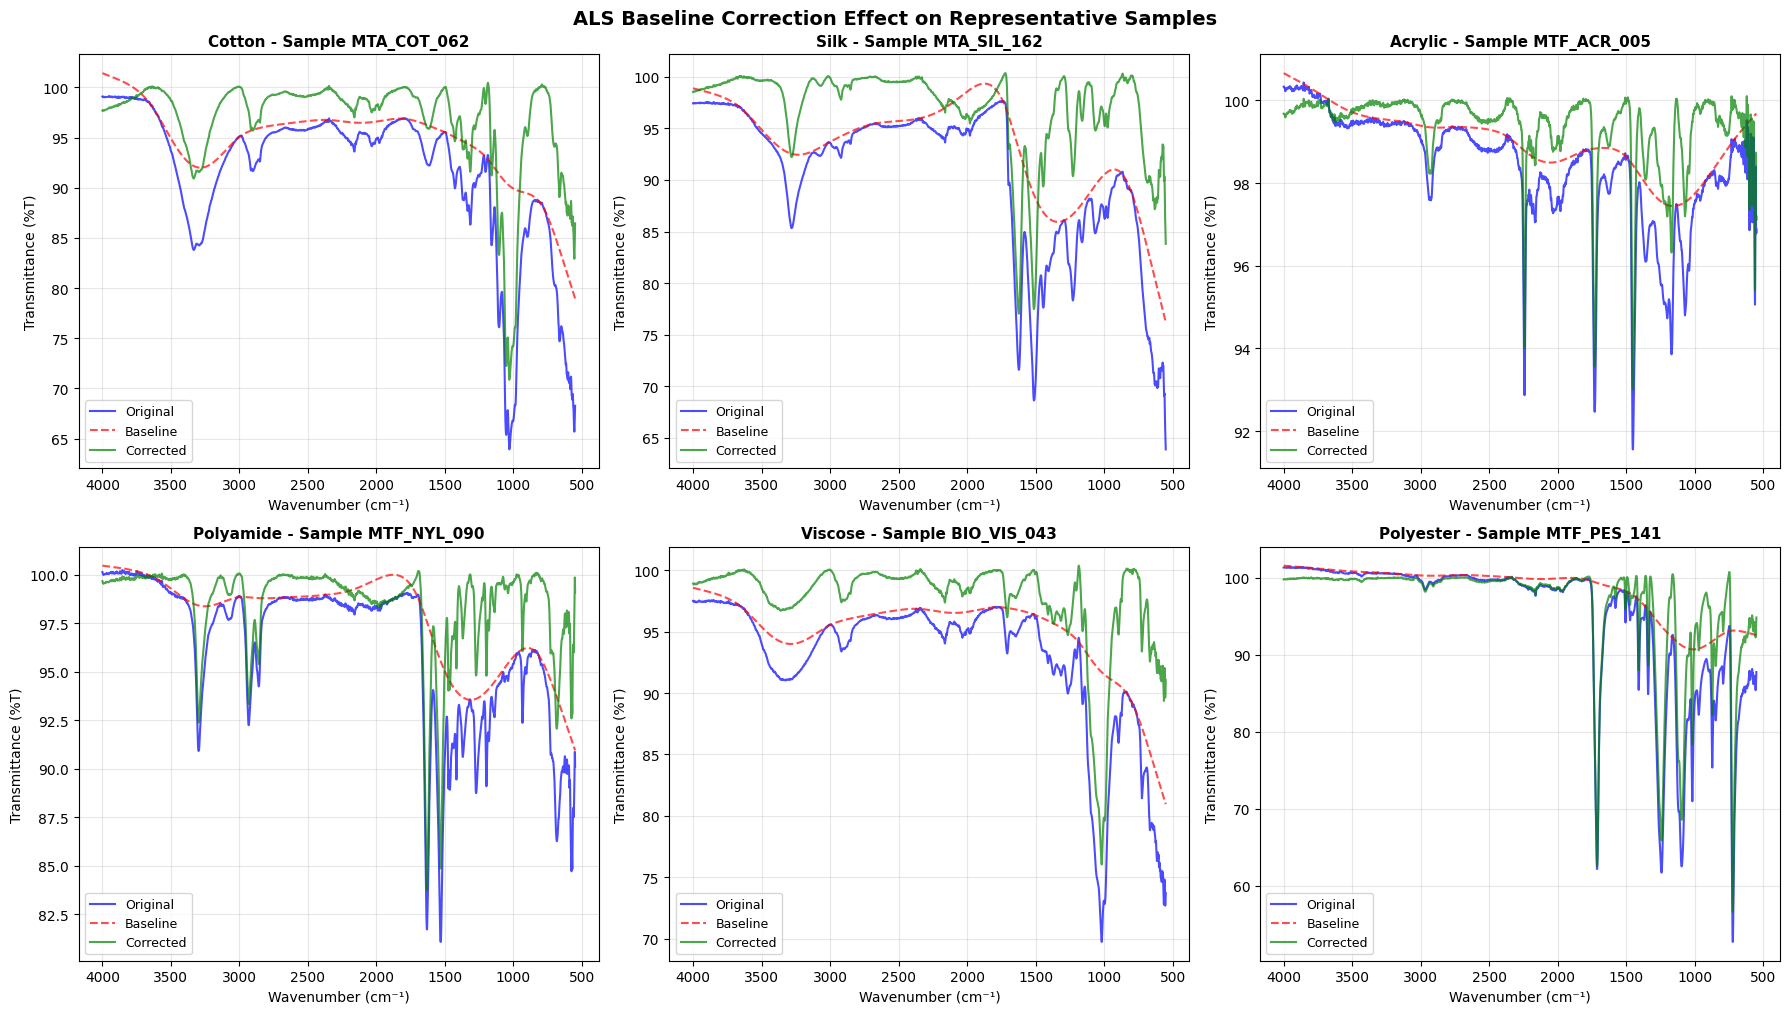

Baseline correction visualization complete


In [142]:
# Visualize baseline correction effect on sample spectra
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Select representative samples from different fiber types
# For natural fibers: use Subtype (Cotton, Silk)
# For man-made fibers: use Type (Acrylic, Polyamide, Polyester) or Regenerated cellulose -> Rayon
sample_filters = [
    ('Subtype', 'Cotton'),                                  # Natural - Cellulose
    ('Subtype', 'Silk'),                                    # Natural - Protein
    ('Type', 'Acrylic'),                                    # Man-made
    ('Type', 'Polyamide'),                                  # Man-made
    ('Subtype', 'Viscose'),                                 # Regenerated Cellulose
    ('Type', 'Polyester')                                   # Man-made
]
sample_indices = []
sample_labels = []

for filter_col, filter_val in sample_filters:
    matches = ml_dataset[ml_dataset[filter_col] == filter_val]
    if not matches.empty:
        idx = matches.index[0]
        sample_indices.append(idx)
        sample_labels.append(filter_val)

# Plot original vs baseline-corrected spectra
for i, (label, idx) in enumerate(zip(sample_labels, sample_indices)):
    row_idx = i // 3
    col_idx = i % 3
    
    # Get original and corrected spectra
    original = ml_dataset.loc[idx, spectral_columns].values.astype(np.float64)
    corrected = ml_dataset_baseline_corrected.loc[idx, spectral_columns].values
    
    # Convert original to absorbance and get baseline
    abs_original = -np.log10((original + 1e-10) / 100.0)
    baseline_abs = als_baseline_correction(abs_original, lam=1e6, p=0.001, max_iter=10)
    # Convert baseline back to %T for visualization
    baseline = 100.0 * np.power(10, -baseline_abs)
    
    # Plot
    axes[row_idx, col_idx].plot(wavenumbers_ref, original, 'b-', linewidth=1.5, 
                                label='Original', alpha=0.7)
    axes[row_idx, col_idx].plot(wavenumbers_ref, baseline, 'r--', linewidth=1.5, 
                                label='Baseline', alpha=0.7)
    axes[row_idx, col_idx].plot(wavenumbers_ref, corrected, 'g-', linewidth=1.5, 
                                label='Corrected', alpha=0.7)
    
    axes[row_idx, col_idx].set_xlabel('Wavenumber (cm⁻¹)', fontsize=10)
    axes[row_idx, col_idx].set_ylabel('Transmittance (%T)', fontsize=10)
    axes[row_idx, col_idx].set_title(f'{label} - Sample {ml_dataset.loc[idx, "Sample_ID"]}', 
                                    fontsize=11, fontweight='bold')
    axes[row_idx, col_idx].legend(fontsize=9)
    axes[row_idx, col_idx].grid(True, alpha=0.3)
    axes[row_idx, col_idx].invert_xaxis()

plt.tight_layout()
plt.suptitle('ALS Baseline Correction Effect on Representative Samples', 
            fontsize=14, fontweight='bold', y=1.01)
plt.show()

print("Baseline correction visualization complete")


In [143]:
# Export baseline-corrected dataset
baseline_corrected_path = output_dir / 'feature_matrix_baseline_corrected_T.csv'
ml_dataset_baseline_corrected.to_csv(baseline_corrected_path, index=False)

print(f"Baseline-corrected dataset exported to: {baseline_corrected_path}")
print(f"File size: {baseline_corrected_path.stat().st_size / 1024 / 1024:.2f} MB")
print(f"Shape: {ml_dataset_baseline_corrected.shape}")
print(f"Columns: {list(ml_dataset_baseline_corrected.columns[:10])}...")

print("\n" + "=" * 80)
print("BASELINE CORRECTION EXPORT COMPLETE")
print("=" * 80)
print("\nDataset Summary:")
print(f"  - Original dataset: {ml_dataset.shape[0]} spectra")
print(f"  - Baseline-corrected dataset: {ml_dataset_baseline_corrected.shape[0]} spectra")
print(f"  - Method: Asymmetric Least Squares (ALS)")
print(f"  - Parameters: lambda=1e6, p=0.001, iterations=10")
print(f"  - Data format: Transmittance (%T) baseline-corrected via absorbance conversion")
print(f"  - Workflow: %T → Absorbance → ALS correction → back to %T")
print("=" * 80)


Baseline-corrected dataset exported to: ml_datasets\feature_matrix_baseline_corrected_T.csv
File size: 9.45 MB
Shape: (160, 3457)
Columns: ['Spectrum_ID', 'Sample_ID', 'Replica', 'Origin', 'Type', 'Subtype', '4000.0', '3999.0', '3998.0', '3997.0']...

BASELINE CORRECTION EXPORT COMPLETE

Dataset Summary:
  - Original dataset: 160 spectra
  - Baseline-corrected dataset: 160 spectra
  - Method: Asymmetric Least Squares (ALS)
  - Parameters: lambda=1e6, p=0.001, iterations=10
  - Data format: Transmittance (%T) baseline-corrected via absorbance conversion
  - Workflow: %T → Absorbance → ALS correction → back to %T


### Create All Samples Metadata (from natural.csv, synthetic.csv, and internal.csv)

In [144]:
# Build comprehensive metadata from all samples in natural.csv, synthetic.csv, and internal.csv
all_samples_metadata = []

#####################################################################################
# Process natural fibres
print("Building all samples metadata...")
print("=" * 80)

for idx, row in natural_df.iterrows():
    binder_id = str(row['Binder Location']).strip()
    fibre_name = str(row['Type']).strip() if 'Type' in row else 'Unknown'
    details = str(row['Details']).strip() if not pd.isna(row['Details']) else ''
    
    # Skip if fibre name not in our mapping
    if fibre_name not in FIBRE_ORIGIN:
        print(f"  Skipping unknown fibre: {fibre_name}")
        continue
    
    # Determine hierarchical Type
    if fibre_name in CELLULOSE_FIBRES:
        fibre_type = 'Cellulose'
    elif fibre_name in PROTEIN_FIBRES:
        fibre_type = 'Protein'
    else:
        fibre_type = fibre_name
    
    # Generate Sample_ID with new structured format: CCC_TTT_NNN
    collection_code = 'MTA'  # Arbidar Natural Fibre Collection
    material_code = FIBRE_ABBREVIATIONS[fibre_name]
    numerical_part = binder_id.replace('.', '')
    numerical_code = numerical_part.zfill(3)
    sample_id = f"{collection_code}_{material_code}_{numerical_code}"
    
    # Extract subtype
    fibre_subtype = extract_subtype_from_remarks(details, fibre_name)
    
    # Extract color
    color = extract_colour_from_text(details)
    
    all_samples_metadata.append({
        'Sample_ID': sample_id,
        'Source': 'Microtraces LTD',
        'Collection': 'Arbidar Natural Fibre Collection',
        'Binder_ID': binder_id,
        'Manufacturer': 'N/A',
        'Origin': 'Natural',
        'Type': fibre_type,
        'Subtype': fibre_subtype,
        'Apparent_Colour': color if color else 'N/A',
        'Details': details,
        'Scanned': 'Yes' if sample_id in seen_samples else 'No'
    })

print(f"Processed {len(natural_df)} natural fibre samples")
print(f"  Added {len([s for s in all_samples_metadata if s['Origin'] == 'Natural'])} to metadata")


#######################################################################################
# Process synthetic fibres
for idx, row in synthetic_df.iterrows():
    num_id = row['Num.']
    fibre_name = str(row['Generic Class']).strip() if 'Generic Class' in row else 'Unknown'
    manufacturer = str(row['Manufacturer Trade Name']).strip() if not pd.isna(row['Manufacturer Trade Name']) else 'N/A'
    details = str(row['Remarks']).strip() if not pd.isna(row['Remarks']) else ''
    
    # Skip if fibre name not in our mapping
    if fibre_name not in FIBRE_ORIGIN:
        # Don't print for each unknown to avoid clutter
        continue
    
    # Determine hierarchical Type based on fibre name
    if fibre_name in REGENERATED_CELLULOSE:
        fibre_type = 'Regenerated cellulose'
    elif fibre_name in ACETATE_FIBRES:
        fibre_type = 'Cellulose acetate'
    elif fibre_name == 'Nylon':
        fibre_type = 'Polyamide'
    elif fibre_name == 'Acrylic':
        fibre_type = 'Acrylic'
    elif fibre_name == 'Modacrylic':
        fibre_type = 'Modacrylic'
    elif fibre_name == 'Olefin':
        fibre_type = 'Polyolefin'
    elif fibre_name == 'Aramid':
        fibre_type = 'Aramid'
    elif fibre_name == 'Spandex':
        fibre_type = 'Elastane'
    else:
        # For other fibers (Polyester, Carbon, etc.)
        fibre_type = fibre_name
    
    # Generate Sample_ID with new structured format: CCC_TTT_NNN
    collection_code = 'MTF'  # Microtrace Forensic Fiber Reference Collection
    material_code = FIBRE_ABBREVIATIONS[fibre_name]
    binder_id = str(num_id)
    numerical_code = binder_id.zfill(3)
    sample_id = f"{collection_code}_{material_code}_{numerical_code}"
    
    # Extract subtype
    fibre_subtype = extract_subtype_from_remarks(details, fibre_name)
    
    # Extract color
    color = extract_colour_from_text(details)
    
    all_samples_metadata.append({
        'Sample_ID': sample_id,
        'Source': 'Microtraces LTD',
        'Collection': 'Microtrace Forensic Fiber Reference Collection',
        'Binder_ID': binder_id,
        'Manufacturer': manufacturer,
        'Origin': 'Man-made',
        'Type': fibre_type,
        'Subtype': fibre_subtype,
        'Apparent_Colour': color if color else 'N/A',
        'Details': details,
        'Scanned': 'Yes' if sample_id in seen_samples else 'No'
    })
   
print(f"Processed {len(synthetic_df)} man-made fibre samples")
print(f"  Added {len([s for s in all_samples_metadata if s['Origin'] == 'Man-made'])} to metadata")


#######################################################################################
# Process internal fibres
for idx, row in internal_df.iterrows():
    binder_id = str(row['Binder Location']).strip()
    fibre_name = str(row['Generic Classs']).strip() if 'Generic Classs' in row else 'Unknown'
    source_name = str(row['Source']).strip()
    details = str(row['Description']).strip() if not pd.isna(row['Description']) else ''
    
    # Handle Unknown or unmapped Generic Class
    if fibre_name not in FIBRE_ORIGIN and fibre_name != 'Unknown':
        print(f"  Warning: Unmapped fibre type '{fibre_name}' - treating as Unknown")
        fibre_name = 'Unknown'
    
    # Determine origin (Unknown defaults to Man-made)
    if fibre_name == 'Unknown':
        origin = 'Man-made'
        fibre_type = 'Unknown'
    else:
        origin = FIBRE_ORIGIN[fibre_name]
        
        # Determine hierarchical Type
        if fibre_name in CELLULOSE_FIBRES:
            fibre_type = 'Cellulose'
        elif fibre_name in PROTEIN_FIBRES:
            fibre_type = 'Protein'
        elif fibre_name in REGENERATED_CELLULOSE:
            fibre_type = 'Regenerated cellulose'
        elif fibre_name in ACETATE_FIBRES:
            fibre_type = 'Cellulose acetate'
        elif fibre_name == 'Nylon':
            fibre_type = 'Polyamide'
        elif fibre_name == 'Acrylic':
            fibre_type = 'Acrylic'
        elif fibre_name == 'Modacrylic':
            fibre_type = 'Modacrylic'
        elif fibre_name == 'Olefin':
            fibre_type = 'Polyolefin'
        elif fibre_name == 'Aramid':
            fibre_type = 'Aramid'
        elif fibre_name == 'Spandex':
            fibre_type = 'Elastane'
        else:
            fibre_type = fibre_name
    
    # Generate Sample_ID with new structured format: CCC_TTT_NNN
    if source_name == 'Bio-Couture':
        collection_code = 'BIO'
    elif source_name == 'UNUSUWUL':
        collection_code = 'UNU'
    else:
        collection_code = 'INT'
    
    material_code = FIBRE_ABBREVIATIONS.get(fibre_name, 'UNK')
    numerical_part = binder_id.replace('.', '')
    numerical_code = numerical_part.zfill(3)
    sample_id = f"{collection_code}_{material_code}_{numerical_code}"
    
    # Extract subtype
    fibre_subtype = extract_subtype_from_remarks(details, fibre_name)
    
    # Extract color
    color = extract_colour_from_text(details)
    
    all_samples_metadata.append({
        'Sample_ID': sample_id,
        'Source': source_name,
        'Collection': 'Internal Collection',
        'Binder_ID': binder_id,
        'Manufacturer': 'N/A',
        'Origin': origin,
        'Type': fibre_type,
        'Subtype': fibre_subtype,
        'Apparent_Colour': color if color else 'N/A',
        'Details': details,
        'Scanned': 'Yes' if sample_id in seen_samples else 'No'
    })

print(f"Processed {len(internal_df)} internal fibre samples")
print(f"  Added {len([s for s in all_samples_metadata if s['Collection'] == 'Internal Collection'])} to metadata")

# Create DataFrame
all_samples_df = pd.DataFrame(all_samples_metadata)

print(f"\nTotal samples in all_samples metadata: {len(all_samples_df)}")
print(f"  Expected: 78 natural + 201 man-made + {len(internal_df)} internal = {78 + 201 + len(internal_df)} total")
print(f"Scanned samples: {len(all_samples_df[all_samples_df['Scanned'] == 'Yes'])}")
print(f"Not scanned: {len(all_samples_df[all_samples_df['Scanned'] == 'No'])}")

print("\nType Distribution:")
print(all_samples_df['Type'].value_counts())

print("\nFirst 10 rows:")
print(all_samples_df.head(10))

Building all samples metadata...
  Skipping unknown fibre: Cotton Linen Blend
  Skipping unknown fibre: Rabbit and Sheep
  Skipping unknown fibre: Silk and Merino wool
  Skipping unknown fibre: Abaca hemp
  Skipping unknown fibre: Bagasse (sugarcane)
  Skipping unknown fibre: Cogan Grass
  Skipping unknown fibre: Gampi
  Skipping unknown fibre: Kozo
  Skipping unknown fibre: Rice
  Skipping unknown fibre: Straw
  Skipping unknown fibre: Tree bark
Processed 78 natural fibre samples
  Added 67 to metadata
Processed 201 man-made fibre samples
  Added 200 to metadata
Processed 57 internal fibre samples
  Added 57 to metadata

Total samples in all_samples metadata: 324
  Expected: 78 natural + 201 man-made + 57 internal = 336 total
Scanned samples: 137
Not scanned: 187

Type Distribution:
Type
Protein                  78
Polyester                55
Polyamide                48
Acrylic                  44
Cellulose                36
Regenerated cellulose    19
Modacrylic               16
Poly

In [145]:
# Export all samples metadata
all_samples_path = output_dir / 'all_samples_metadata.csv'
all_samples_df.to_csv(all_samples_path, index=False)
print(f"\nAll Samples Metadata exported to: {all_samples_path}")
print(f"File size: {all_samples_path.stat().st_size / 1024:.2f} KB")
print(f"Total samples: {len(all_samples_df)}")
print(f"  - Scanned: {len(all_samples_df[all_samples_df['Scanned'] == 'Yes'])}")
print(f"  - Not scanned: {len(all_samples_df[all_samples_df['Scanned'] == 'No'])}")


All Samples Metadata exported to: ml_datasets\all_samples_metadata.csv
File size: 54.45 KB
Total samples: 324
  - Scanned: 137
  - Not scanned: 187


## Step 9: Verification and Sample Inspection

In [146]:
# Verify the exported files can be read back
print("Verifying exported files...")
print("=" * 80)

# Read back ML dataset
ml_verify = pd.read_csv(ml_dataset_path)
print(f"\nML Dataset verification:")
print(f"Shape: {ml_verify.shape}")
print(f"Columns: {len(ml_verify.columns)}")
print(f"Rows: {len(ml_verify)}")

# Read back scanned samples metadata
scanned_metadata_verify = pd.read_csv(scanned_metadata_path)
print(f"\nScanned Samples Metadata verification:")
print(f"Shape: {scanned_metadata_verify.shape}")
print(f"Columns: {list(scanned_metadata_verify.columns)}")
print(f"Rows: {len(scanned_metadata_verify)}")

# Read back all samples metadata
all_samples_verify = pd.read_csv(all_samples_path)
print(f"\nAll Samples Metadata verification:")
print(f"Shape: {all_samples_verify.shape}")
print(f"Columns: {list(all_samples_verify.columns)}")
print(f"Rows: {len(all_samples_verify)}")
print(f"  - Scanned: {len(all_samples_verify[all_samples_verify['Scanned'] == 'Yes'])}")
print(f"  - Not scanned: {len(all_samples_verify[all_samples_verify['Scanned'] == 'No'])}")

# Read back statistics
# stats_verify = pd.read_csv(stats_path)
# print(f"\nStatistics verification:")
# print(f"Shape: {stats_verify.shape}")
# print(f"Rows: {len(stats_verify)}")

print("\nAll files verified successfully!")

Verifying exported files...

ML Dataset verification:
Shape: (160, 3457)
Columns: 3457
Rows: 160

Scanned Samples Metadata verification:
Shape: (137, 10)
Columns: ['Sample_ID', 'Source', 'Collection', 'Binder_ID', 'Manufacturer', 'Origin', 'Type', 'Subtype', 'Apparent_Colour', 'Details']
Rows: 137

All Samples Metadata verification:
Shape: (324, 11)
Columns: ['Sample_ID', 'Source', 'Collection', 'Binder_ID', 'Manufacturer', 'Origin', 'Type', 'Subtype', 'Apparent_Colour', 'Details', 'Scanned']
Rows: 324
  - Scanned: 137
  - Not scanned: 187

All files verified successfully!


In [147]:
# Inspect specific samples
print("Sample Inspection:")
print("=" * 80)

# Show Cotton samples (now under Cellulose type)
print("\nCotton samples:")
cotton_samples = ml_dataset[ml_dataset['Subtype'] == 'Cotton'][['Spectrum_ID', 'Sample_ID', 'Replica', 'Type', 'Subtype']]
print(cotton_samples)

# Show Acrylic samples
print("\nAcrylic samples:")
acrylic_samples = ml_dataset[ml_dataset['Type'] == 'Acrylic'][['Spectrum_ID', 'Sample_ID', 'Replica', 'Subtype']]
print(acrylic_samples)

# Show regenerated cellulose samples
print("\nRegenerated Cellulose samples:")
regen_samples = ml_dataset[ml_dataset['Type'] == 'Regenerated cellulose'][['Spectrum_ID', 'Sample_ID', 'Subtype']]
print(regen_samples)

Sample Inspection:

Cotton samples:
   Spectrum_ID    Sample_ID  Replica       Type Subtype
24        0025  MTA_COT_062        1  Cellulose  Cotton
25        0026  BIO_COT_012        1  Cellulose  Cotton
26        0027  BIO_COT_041        1  Cellulose  Cotton
27        0028  MTA_COT_062        2  Cellulose  Cotton
28        0029  MTA_COT_063        1  Cellulose  Cotton
29        0030  MTA_COT_064        1  Cellulose  Cotton
30        0031  MTA_COT_072        1  Cellulose  Cotton
31        0032  MTA_COT_071        1  Cellulose  Cotton
32        0033  MTA_COT_062        3  Cellulose  Cotton
33        0034  MTA_COT_061        1  Cellulose  Cotton
34        0035  MTA_COT_061        2  Cellulose  Cotton
35        0036  BIO_COT_011        1  Cellulose  Cotton
36        0037  BIO_COT_013        1  Cellulose  Cotton
37        0038  BIO_COT_012        2  Cellulose  Cotton

Acrylic samples:
   Spectrum_ID    Sample_ID  Replica                              Subtype
4         0005  MTF_ACR_005     

In [148]:
# Final summary report
print("\n" + "=" * 80)
print("DATASET GENERATION SUMMARY REPORT")
print("=" * 80)

print(f"\nTotal spectra in ML dataset: {len(ml_dataset)}")
print(f"Total unique scanned samples: {len(metadata_dataset)}")
print(f"Total samples in database (scanned + not scanned): {len(all_samples_df)}")
print(f"  - Scanned: {len(all_samples_df[all_samples_df['Scanned'] == 'Yes'])}")
print(f"  - Not scanned: {len(all_samples_df[all_samples_df['Scanned'] == 'No'])}")
print(f"\nSpectral data points per spectrum: {len(spectral_columns)}")
print(f"Wavenumber range: {spectral_columns[0]} to {spectral_columns[-1]} cm-1")

print("\nOrigin breakdown (scanned samples):")
for origin, count in ml_dataset['Origin'].value_counts().items():
    percentage = (count / len(ml_dataset)) * 100
    print(f"  {origin}: {count} spectra ({percentage:.1f}%)")

print("\nType breakdown (scanned samples):")
for ftype, count in ml_dataset['Type'].value_counts().items():
    percentage = (count / len(ml_dataset)) * 100
    print(f"  {ftype}: {count} spectra ({percentage:.1f}%)")

print("\nOutput files:")
print(f"  1. {ml_dataset_path.name}")
print(f"     - ML-ready dataset with raw spectral data (Transmittance %T)")
print(f"  2. baseline_corrected_spectra.csv")
print(f"     - ALS baseline-corrected spectra (Transmittance %T, baseline removed)")
print(f"  3. {scanned_metadata_path.name}")
print(f"     - Metadata for scanned samples only ({len(metadata_dataset)} samples)")
print(f"  4. {all_samples_path.name}")
print(f"     - Metadata for all available samples ({len(all_samples_df)} samples)")
# print(f"  5. {stats_path.name}")
# print(f"     - Preprocessing statistics")
print(f"  6. representative_spectra_by_subtype.csv - created next")
print(f"     - Representative (averaged) baseline-corrected spectra for each subtype")



DATASET GENERATION SUMMARY REPORT

Total spectra in ML dataset: 160
Total unique scanned samples: 137
Total samples in database (scanned + not scanned): 324
  - Scanned: 137
  - Not scanned: 187

Spectral data points per spectrum: 3451
Wavenumber range: 4000.0 to 550.0 cm-1

Origin breakdown (scanned samples):
  Man-made: 102 spectra (63.7%)
  Natural: 58 spectra (36.2%)

Type breakdown (scanned samples):
  Protein: 36 spectra (22.5%)
  Cellulose: 22 spectra (13.8%)
  Regenerated cellulose: 19 spectra (11.9%)
  Modacrylic: 18 spectra (11.2%)
  Polyamide: 18 spectra (11.2%)
  Polyester: 17 spectra (10.6%)
  Acrylic: 14 spectra (8.8%)
  Polyolefin: 8 spectra (5.0%)
  Cellulose acetate: 4 spectra (2.5%)
  Aramid: 4 spectra (2.5%)

Output files:
  1. feature_matrix_raw_transmittance.csv
     - ML-ready dataset with raw spectral data (Transmittance %T)
  2. baseline_corrected_spectra.csv
     - ALS baseline-corrected spectra (Transmittance %T, baseline removed)
  3. scanned_samples_metadat

## Step 10: Create Representative Spectra by Subtype

In [149]:
# Create representative spectra by averaging all baseline-corrected spectra for each subtype
print("Creating representative spectra by subtype...")
print("=" * 80)

# Get spectral columns
spectral_columns = [col for col in ml_dataset_baseline_corrected.columns if col not in 
                   ['Spectrum_ID', 'Sample_ID', 'Replica', 'Origin', 'Type', 'Subtype']]

# Group by Origin, Type, and Subtype
grouped = ml_dataset_baseline_corrected.groupby(['Origin', 'Type', 'Subtype'])

# Create representative spectra records
representative_records = []

for (origin, ftype, subtype), group in grouped:
    # Calculate mean spectrum across all samples of this subtype
    mean_spectrum = group[spectral_columns].mean()
    
    # Count unique samples and total spectra
    num_samples = group['Sample_ID'].nunique()
    num_spectra = len(group)
    
    # Create record
    record = {
        'Origin': origin,
        'Type': ftype,
        'Subtype': subtype,
        'Num_Samples': num_samples,
        'Num_Spectra': num_spectra
    }
    
    # Add mean spectral values
    for col in spectral_columns:
        record[col] = mean_spectrum[col]
    
    representative_records.append(record)
    
    print(f"  {subtype}: {num_samples} samples, {num_spectra} spectra averaged")

# Create DataFrame
representative_spectra_df = pd.DataFrame(representative_records)

print("\n" + "=" * 80)
print(f"Representative spectra created: {len(representative_spectra_df)} subtypes")
print(f"\nDataFrame shape: {representative_spectra_df.shape}")
print(f"\nFirst 5 rows (metadata only):")
print(representative_spectra_df[['Origin', 'Type', 'Subtype', 'Num_Samples', 'Num_Spectra']].head())

Creating representative spectra by subtype...
  PAN/AA/MA: 2 samples, 2 spectra averaged
  PAN/MA: 7 samples, 7 spectra averaged
  PAN/MMA/MA: 1 samples, 3 spectra averaged
  PAN/VA: 1 samples, 1 spectra averaged
  Unspecified PAN (Acrylic) Copolymer: 1 samples, 1 spectra averaged
  Meta-Aramid: 1 samples, 1 spectra averaged
  Para-Aramid: 2 samples, 2 spectra averaged
  Unspecified Aramid Type: 1 samples, 1 spectra averaged
  Cellulose Diacetate: 3 samples, 3 spectra averaged
  Cellulose Triacetate: 1 samples, 1 spectra averaged
  PAN/VA/VC: 5 samples, 5 spectra averaged
  PAN/VBr: 1 samples, 2 spectra averaged
  PAN/VC: 2 samples, 2 spectra averaged
  PAN/VDC: 3 samples, 4 spectra averaged
  Unspecified PAN (Modacrylic) Copolymer: 4 samples, 5 spectra averaged
  PA 6: 10 samples, 10 spectra averaged
  PA 6,6: 6 samples, 7 spectra averaged
  Unspecified PA Copolymer: 1 samples, 1 spectra averaged
  PET: 15 samples, 17 spectra averaged
  PE: 1 samples, 1 spectra averaged
  PP: 7 sample

In [150]:
# Export representative spectra
representative_spectra_path = output_dir / 'feature_matrix_baseline_corrected_average_T.csv'
representative_spectra_df.to_csv(representative_spectra_path, index=False)

print(f"Representative spectra exported to: {representative_spectra_path}")
print(f"File size: {representative_spectra_path.stat().st_size / 1024:.2f} KB")
print(f"Total subtypes: {len(representative_spectra_df)}")
print(f"\nBreakdown by Origin:")
print(representative_spectra_df['Origin'].value_counts())
print(f"\nBreakdown by Type:")
print(representative_spectra_df['Type'].value_counts())

Representative spectra exported to: ml_datasets\feature_matrix_baseline_corrected_average_T.csv
File size: 1890.96 KB
Total subtypes: 31

Breakdown by Origin:
Origin
Man-made    25
Natural      6
Name: count, dtype: int64

Breakdown by Type:
Type
Acrylic                  5
Modacrylic               5
Regenerated cellulose    4
Aramid                   3
Cellulose                3
Polyamide                3
Protein                  3
Cellulose acetate        2
Polyolefin               2
Polyester                1
Name: count, dtype: int64
